In [1]:
import os
import glob
import functions
from multiprocessing import Pool
from functools import partial
import openamundsen as oa


## 1 Erstelle Yaml Files (beliebig viele)

In [2]:
########### USER INPUT
#Diese Werte kann angepasst werden.
values = ["wald 00p" , "wald 10p", "wald 20p", "wald 30p", "wald 40p", "wald 50p", "wald 60p", "wald 70p", "wald 80p", "wald 90p", "wald 100p", "realndsm"]
#Pfad anpassen an den Speicherort
cwd = os.getcwd()

homeFolder = cwd
print(homeFolder)

/Users/ritchyk/OneDrive/Dokumente/Studium/GlobalerWandel_ReginaleNachhaltigkeit/21SS_Gebirgsforschung/openAMUNDSEN/Waldgrenzsensitivität


In [3]:
# Function Definitions Performing Modeling with openAMUNDSEN
############################################################

def perform_modeling(a_yml_file):
    import openamundsen as oa
    config = oa.read_config(a_yml_file)  # read in configuration file
    model = oa.OpenAmundsen(config)  # create OpenAmundsen object and populate unspecified parameters with default values
    model.initialize()
    model.run()

In [4]:
def creating_new_yml_file (a_path, a_input_file, a_change_value):
    import yaml
    import os
    import regex
    import glob
    import json
    import shutil

    # manipulating yml file
    with open(a_input_file) as yml_file:
        dict_yml = yaml.safe_load(yml_file)

    yaml_suffix = str(a_change_value)
    
    
    #looping through yml file
    for i in dict_yml:
        if i == "results_dir":
            #for x in yml_file[i]:
            dict_yml[i] = dict_yml[i] + "/"+yaml_suffix
        if i == "input_data":
            grid_dir = dict_yml[i]["grids"]["dir"]
            dict_yml[i]["grids"]["dir"] += "_" + yaml_suffix
            #print(type(grid_dir), dict_yml[i]["grids"]["dir"])
    
    for dir in glob.glob("./data/*"):
        if dir == "./data/grid":
            new_dir = dir+"_"+yaml_suffix
            if os.path.isdir(new_dir):
                shutil.rmtree(new_dir, ignore_errors=True)
            os.mkdir(new_dir)
            
            all_files = glob.glob(dir+"/*")
            for i in all_files:
                lc = regex.search(r"./lc_.+", i)
                if lc:
                    continue
                shutil.copy(i, new_dir+"/"+os.path.basename(i))
            #print(all_files)
    waldstufen_asc_dir = "./wald_stufen/"
    lc_asc_name = "lc_horlachtal_100.asc"
    for land_cover in glob.glob(waldstufen_asc_dir+"*"):
        #print(land_cover)
        if os.path.basename(land_cover) == a_change_value+".asc":
            shutil.copy(land_cover, new_dir+"/"+lc_asc_name)      
      
    #creating new yml file
    
    with open(f"{a_path}horlachtal_hoehenstufe_{yaml_suffix}.yml", "w") as new_yml_file:
        output = yaml.dump(dict_yml, new_yml_file)
    print(f"creating a new yaml file in {a_path} based on {a_input_file} and with the modified scf value of {a_change_value}")

In [5]:
os.chdir(homeFolder)
#Ordner wo die yaml files hingeschrieben werden und die Vorlage liegt.
path_yml = r"ymls/"
vorlageYaml = r"horlachtal.yml"

for each_hohenstufe in values:
    creating_new_yml_file(path_yml, vorlageYaml, each_hohenstufe)
print(os.getcwd())
for yml_files in glob.glob(os.path.join(path_yml, "horlachtal_*")):
    print(yml_files)
    #perform_modeling(yml_files)
    


creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 00p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 10p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 20p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 30p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 40p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 50p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 60p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 70p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified scf value of wald 80p
creating a new yaml file in ymls/ based on horlachtal.yml and with the modified sc

In [6]:
import xarray as xr
import pandas as pd

results_dir_3h = "results"
results_dir_d = "results_D_with_canopy_var"
def create_monthly_df(a_results_path):
    ALL_MODEL_df = pd.DataFrame()
    counter = 0
    for output in os.listdir(homeFolder + "/"+a_results_path+"/"):
        # if counter >= 1:
        #     continue
        if output == ".DS_Store":
            continue
        ds = xr.open_dataset(f"{a_results_path}/{output}/output_grids.nc")
        df = ds.to_dataframe()
        df = df.reset_index()
        df = df.dropna(subset=["temp_month"])
        df = df.fillna(0)
        df["abfluss"] = df["runoff"] - df["evapotranspiration"] - df["canopy_sublimation"]
        df["abfluss_ohne_sublimation"] = df["runoff"] - df["evapotranspiration"] - df["canopy_sublimation"]
        df["verdunstung_ohne_sublimation"] = df["evapotranspiration"] + df["canopy_sublimation"]
        df["verdunstung"] = df["evapotranspiration"] + df["canopy_sublimation"] +df["sublimation"]
        df["month"] = df.time.dt.to_period('M')
        df.to_csv(f"{homeFolder}/DEBUG.csv")
        df = df.drop(["y", "x", "crs", "time_bounds", "nbnd"], axis=1)
        df_monthly_mean = df.groupby(["month"]).mean()#agg({"runoff": "sum", "snowdepth_month" : "mean", "evapotranspiration": ["sum", "mean"] })
        df_monthly_mean["model"] = output
        df_monthly_mean.to_csv(f"{homeFolder}/DEBUG_month.csv")
        df_monthly_mean.reset_index(inplace=True)
        if counter == 0:
            ALL_MODEL_df = df_monthly_mean.copy()
        else:
            ALL_MODEL_df = pd.concat([ALL_MODEL_df, df_monthly_mean], axis=0)
        counter += 1
        
    display(ALL_MODEL_df.info())
    ALL_MODEL_df = ALL_MODEL_df.sort_values(by=["model", "month"])
    return ALL_MODEL_df

ALL_MODEL_df = create_monthly_df(results_dir_3h)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 12
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype    
---  ------                        --------------  -----    
 0   month                         156 non-null    period[M]
 1   temp_month                    156 non-null    float32  
 2   precip_month                  156 non-null    float32  
 3   swe_month                     156 non-null    float32  
 4   snowdepth_month               156 non-null    float32  
 5   runoff                        156 non-null    float32  
 6   sublimation                   156 non-null    float32  
 7   canopy_sublimation            156 non-null    float32  
 8   snowmelt_month                156 non-null    float32  
 9   evapotranspiration            156 non-null    float32  
 10  abfluss                       156 non-null    float32  
 11  abfluss_ohne_sublimation      156 non-null    float32  
 12  verdunstung_ohne_sublimation  156 non

None

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import numpy as np
COMP_YEAR = ALL_MODEL_df.groupby("model").sum()
COMP_YEAR = COMP_YEAR.sort_values(by=["abfluss"])
COMP_YEAR["Verdunstung"] = COMP_YEAR.canopy_sublimation + COMP_YEAR.evapotranspiration #+ COMP_YEAR.sublimation
display(COMP_YEAR)

palette = {"realndsm" : "tab:red", 
           "wald 00p" : "0.5", 
           "wald 10p" : "0.45", 
           "wald 20p" : "0.4", 
           "wald 30p" : "0.35", 
           "wald 40p" : "0.3", 
           "wald 50p" : "0.25", 
           "wald 60p" : "0.2", 
           "wald 70p" : "0.15", 
           "wald 80p" : "0.1", 
           "wald 90p" : "0.05", 
           "wald 100p" : "0"}

palette_highlight = {"realndsm" : "tab:red", 
                    "wald 00p" : "0.9", 
                    "wald 10p" : "tab:blue", 
                    "wald 20p" : "0.9", 
                    "wald 30p" : "0.9", 
                    "wald 40p" : "0.9", 
                    "wald 50p" : "tab:purple", 
                    "wald 60p" : "0.9", 
                    "wald 70p" : "0.9", 
                    "wald 80p" : "0.9", 
                    "wald 90p" : "tab:brown", 
                    "wald 100p" : "0.9"}


,temp_month,precip_month,swe_month,snowdepth_month,runoff,sublimation,canopy_sublimation,snowmelt_month,evapotranspiration,abfluss,abfluss_ohne_sublimation,verdunstung_ohne_sublimation,verdunstung,Verdunstung
model,,,,,,,,,,,,,,
wald 100p,3560.449219,361.900391,2199.562988,7.111859,283.075134,9.889791,134.438705,312.893219,3.646846,144.989594,144.989594,138.085556,147.975342,138.085556
wald 90p,3560.157471,378.595337,2327.914062,7.503170,289.846344,5.209295,118.630264,324.410950,3.579584,167.636505,167.636505,122.209854,127.419151,122.209846
wald 80p,3560.088135,394.567261,2440.195557,7.850942,301.701263,0.183552,103.310501,340.358124,3.393775,194.996994,194.996994,106.704277,106.887825,106.704277
wald 70p,3560.150879,409.858154,2542.545898,8.173215,317.026123,-5.520926,88.514381,359.041962,3.061796,225.449936,225.449936,91.576180,86.055252,91.576180
wald 60p,3560.324707,424.337189,2638.374512,8.477011,334.407471,-11.913660,74.345062,379.268372,2.722674,257.339722,257.339722,77.067741,65.154076,77.067734
wald 50p,3560.571045,438.435944,2731.502441,8.773899,353.721649,-19.117891,60.477577,401.092346,2.310076,290.934021,290.934021,62.787651,43.669762,62.787655
wald 40p,3560.909668,451.896301,2816.630127,9.048391,375.100403,-26.703255,47.151848,424.210724,1.924627,326.023926,326.023926,49.076477,22.373220,49.076473
wald 30p,3561.347412,464.912842,2898.927246,9.314208,396.993347,-34.825485,34.195122,447.338745,1.578261,361.219971,361.219971,35.773384,0.947899,35.773384
wald 20p,3561.906250,477.177948,2977.409180,9.565638,418.582581,-43.071529,21.932249,469.948944,1.294456,395.355896,395.355896,23.226706,-19.844824,23.226706


In [8]:
prefix = "Durschnittliche"
end = "im Untersuchungsgebiet in mm/m^2"

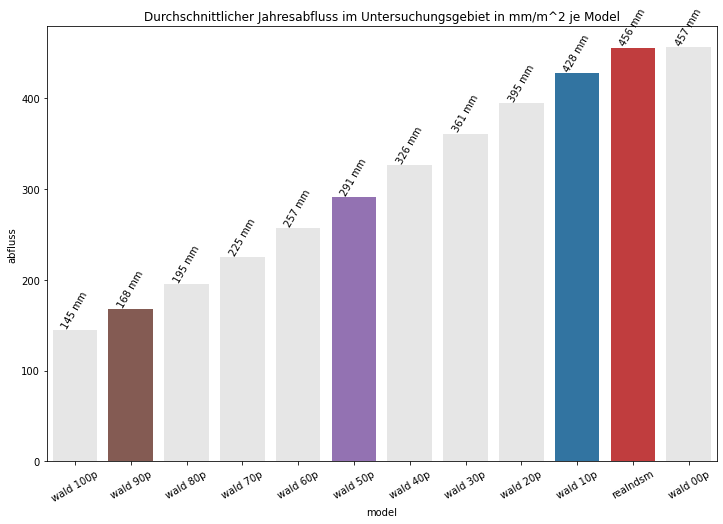

In [9]:
def jahresvergleich_barplot(a_df, a_var, a_title, a_palette, sum_to_year=True):
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    if sum_to_year == True:
        a_df[a_var] = a_df[a_var]
        plot = sns.barplot(data= a_df, x=COMP_YEAR.index, y=a_var, palette=a_palette)
    else:
        plot = sns.barplot(data= a_df, x=COMP_YEAR.index, y=a_var, palette=a_palette)

    plot.set_title(a_title)
    plot.bar_label(ax.containers[0], rotation=60, fmt="%.f mm")
    plot.set_xticklabels(labels=COMP_YEAR.index, rotation=30)
    plot.ticklabel_format(style='plain', axis="y")
    fig = plot.get_figure()
    fig.savefig(f'{homeFolder}/y_{a_var}.svg',dpi=350)
jahresvergleich_barplot(COMP_YEAR, "abfluss", "Durchschnittlicher Jahresabfluss im Untersuchungsgebiet in mm/m^2 je Model", palette_highlight)


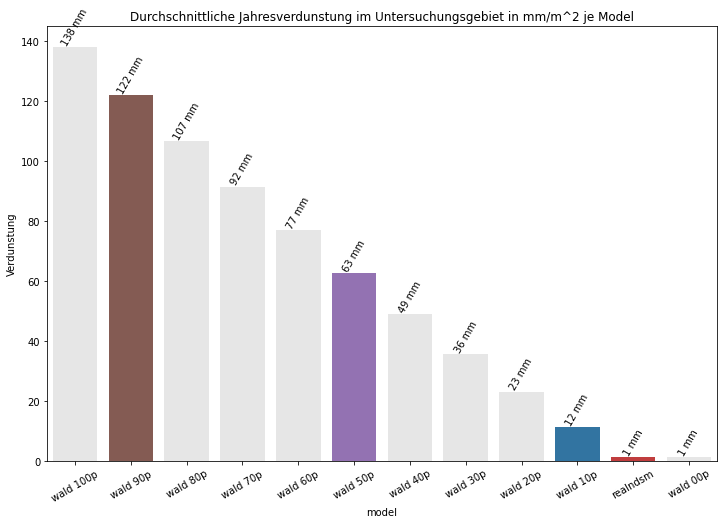

In [10]:
jahresvergleich_barplot(COMP_YEAR, "Verdunstung", "Durchschnittliche Jahresverdunstung im Untersuchungsgebiet in mm/m^2 je Model", palette_highlight)

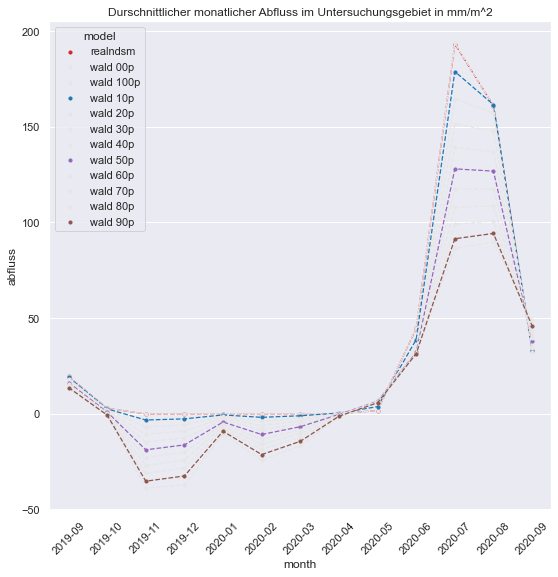

In [24]:
def monatsvergleich_point_plt(a_df, a_var, a_title,  a_palette):
    plot = sns.pointplot(data=a_df, x="month", y=a_var, hue="model", linestyles="--", palette=a_palette)
    fig = plot.get_figure()
    sns.set(rc={"figure.figsize":(9, 9), "lines.linewidth": 0.7})
    plot.set_title(a_title)
    plt.xticks(rotation=45)
    fig.savefig(f'{homeFolder}/m_{a_var}.svg',dpi=350)
monatsvergleich_point_plt(ALL_MODEL_df, "abfluss", f"{prefix}r monatlicher Abfluss {end}", palette_highlight)

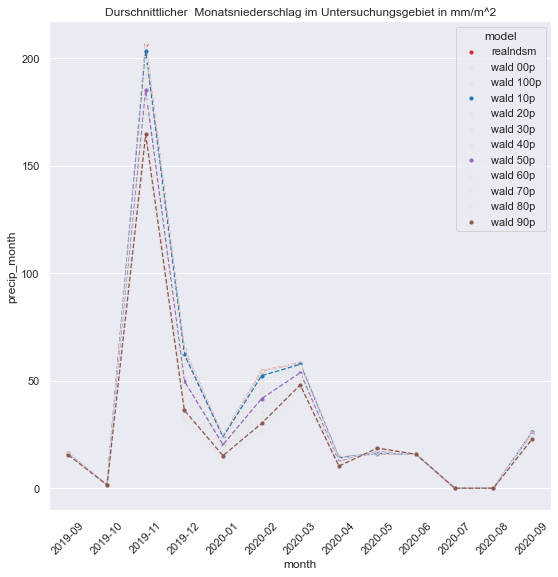

In [12]:
monatsvergleich_point_plt(ALL_MODEL_df, "precip_month", f"{prefix}r  Monatsniederschlag {end}", palette_highlight)

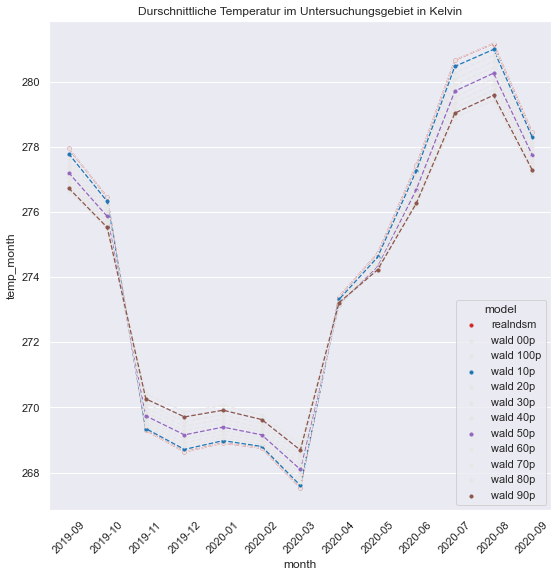

In [13]:
monatsvergleich_point_plt(ALL_MODEL_df, "temp_month", f"{prefix} Temperatur im Untersuchungsgebiet in Kelvin", palette_highlight)

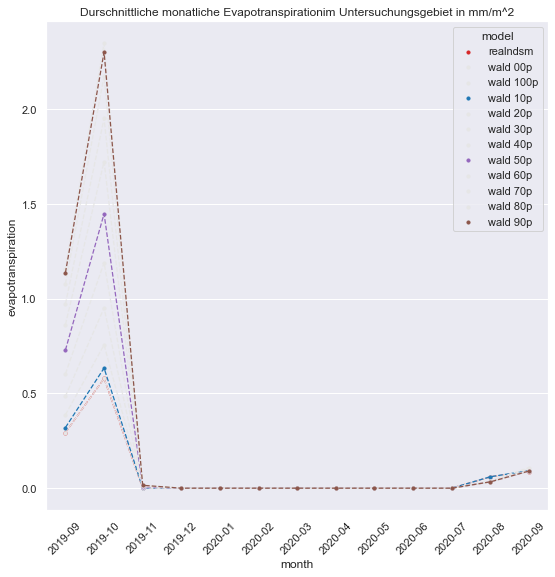

In [14]:
monatsvergleich_point_plt(ALL_MODEL_df, "evapotranspiration", f"{prefix} monatliche Evapotranspiration{end}", palette_highlight)

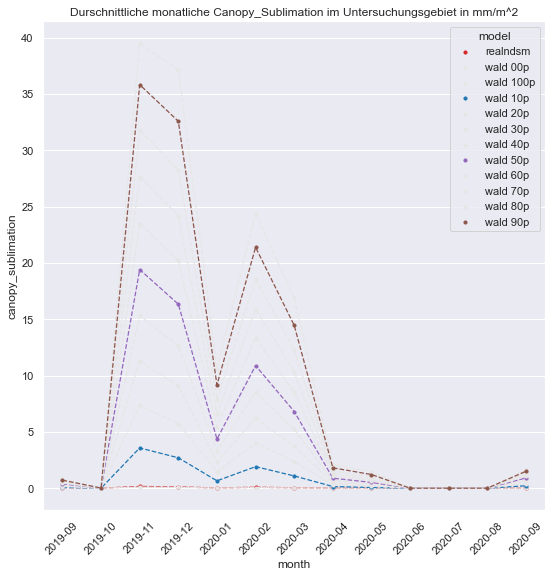

In [15]:
monatsvergleich_point_plt(ALL_MODEL_df, "canopy_sublimation", f"{prefix} monatliche Canopy_Sublimation {end}", palette_highlight)

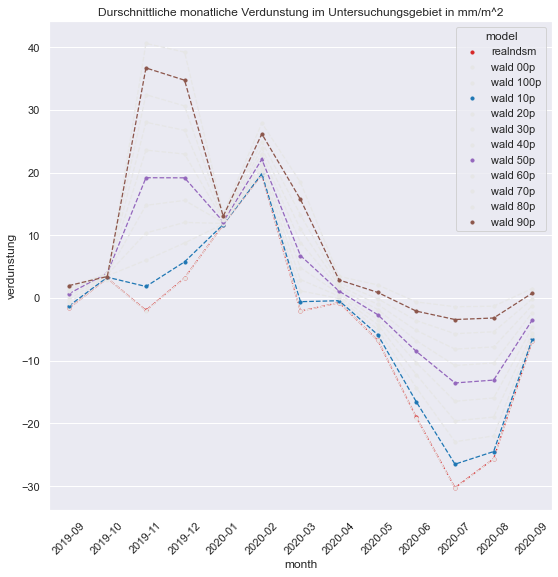

In [16]:
monatsvergleich_point_plt(ALL_MODEL_df, "verdunstung", f"{prefix} monatliche Verdunstung {end}", palette_highlight)

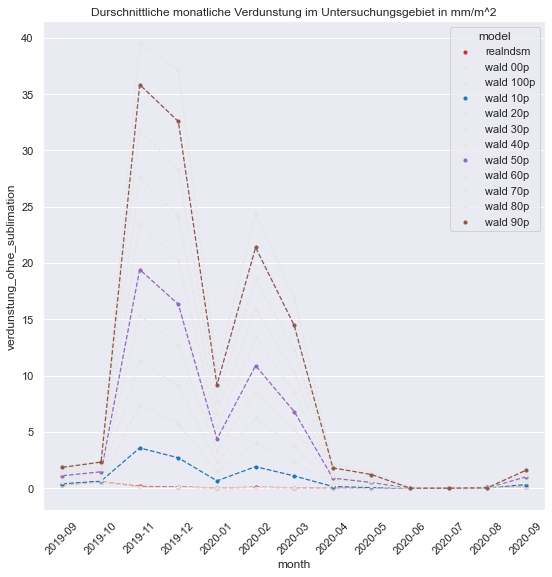

In [17]:
monatsvergleich_point_plt(ALL_MODEL_df, "verdunstung_ohne_sublimation", f"{prefix} monatliche Verdunstung {end}", palette_highlight)

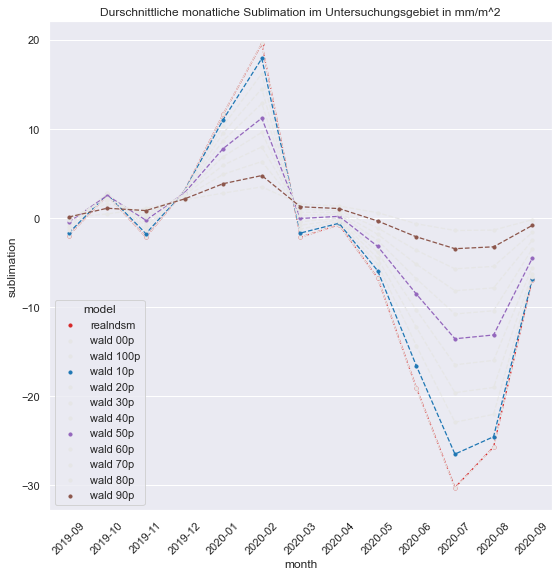

In [18]:
monatsvergleich_point_plt(ALL_MODEL_df, "sublimation", f"{prefix} monatliche Sublimation {end}", palette_highlight)

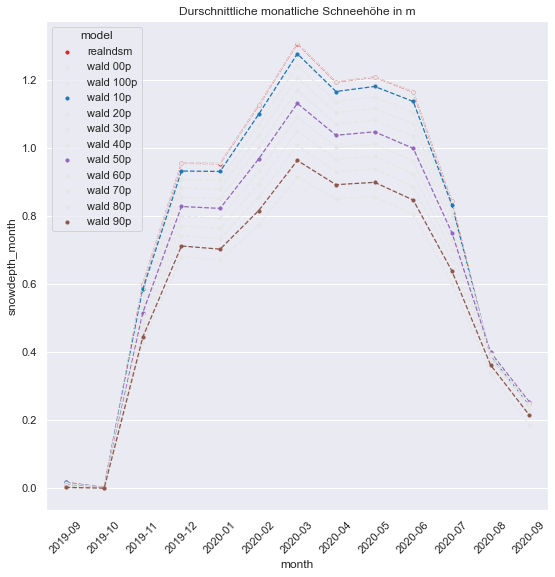

In [19]:
monatsvergleich_point_plt(ALL_MODEL_df, "snowdepth_month", f"{prefix} monatliche Schneehöhe in m", palette_highlight)

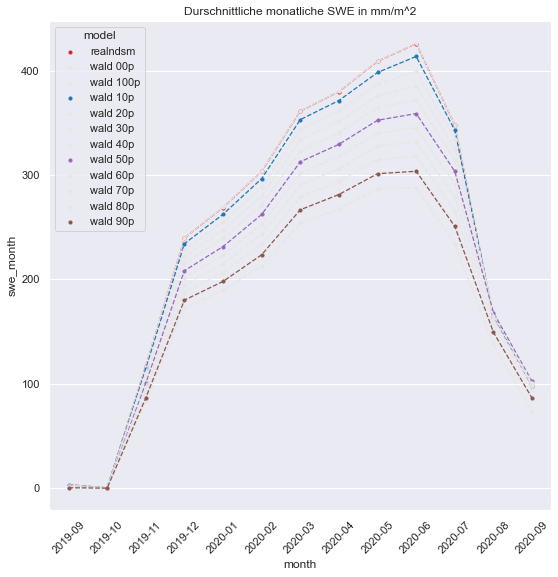

In [20]:
monatsvergleich_point_plt(ALL_MODEL_df, "swe_month", f"{prefix} monatliche SWE in mm/m^2", palette_highlight)

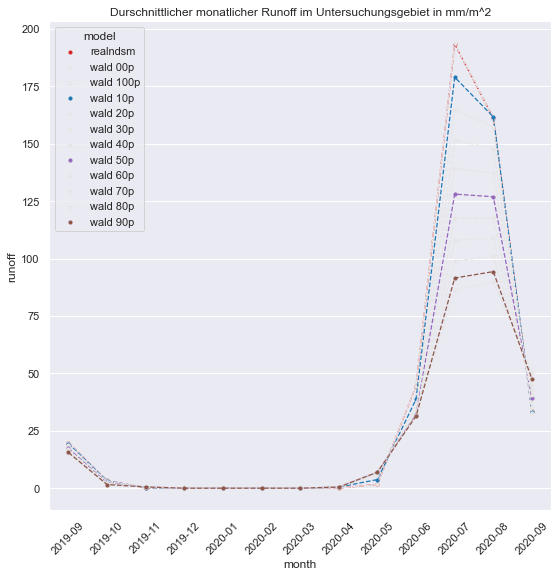

In [21]:
monatsvergleich_point_plt(ALL_MODEL_df, "runoff", f"{prefix}r monatlicher Runoff {end}", palette_highlight)